# Optimization Test

The goal of this notebook is optimizate de potential energy in function of the displacement.

In [1]:
## Import libraires
import jax
import optax
import jaxopt
from jax.scipy.special import logsumexp
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pyvista as pv
import Elements as EL
import Material as mat
from Functions import *
from jax import random
import numpy as np
from tqdm import tqdm
from jax import config
config.update("jax_enable_x64", True)
key = random.key(0)


2024-05-27 18:29:33.745709: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## First Test: Minimize the potential energy, only internal energy consideration

### Unit Block test

In [2]:
#Mesh SET

mesh_file = '/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Meshes/cubo.msh'
mesh = pv.read(mesh_file)  #Orgiinal File
mesh.clear_data()

points_total,connectivity_total,bc_drichlet_cells,bc_drichlet_nodes,bc_neumann_cells,bc_neumann_nodes = Hex_Reader(mesh_file,
                                                                                                        drichlet_bc= ["X_1"],plot = False)


#Dritchlet condition 
bc_drichlet_cells['X_1'] = [bc_drichlet_cells['X_1'], jnp.array([1/1000,0,0]) ]

X_0_index = jnp.where(points_total[:, 0] == 0)[0]
X_1_index = jnp.where(points_total[:, 0] == 1)[0]
Y_0_index = jnp.where(points_total[:, 1] == 0)[0]
Z_0_index = jnp.where(points_total[:, 2] == 0)[0]


X_0_index = X_0_index*3 + 0 
X_1_index = X_1_index*3 + 0 
Y_0_index = Y_0_index*3 + 1
Z_0_index = Z_0_index*3 + 2 

indices_known = jnp.concatenate((X_0_index,X_1_index,Y_0_index,Z_0_index))
index_disp_inc = jnp.delete(jnp.arange(points_total.shape[0]*3),indices_known) 


disp_0  = jnp.zeros_like(points_total).reshape((-1,1))
disp_0 = disp_0.at[X_0_index].set(0)
disp_0 = disp_0.at[X_1_index].set(1)
disp_0 = disp_0.at[Y_0_index].set(0)
disp_0 = disp_0.at[Z_0_index].set(0)



disp_inc = jnp.zeros((index_disp_inc.shape[0],1))

@jit
def u(disp_in):
    global disp_0
    disp_0 = disp_0.at[index_disp_inc].set(disp_in)
    return disp_0.reshape((-1,3))



constant = [0.03,3.77]
material = mat.Delphino(constant,100)
malla = EL.Hexs(material, points_total,connectivity_total)


In [3]:
### Optimization 
#result = result.at[:4, :].set(0)
### Loss function
@jit
def loss_function(disp_in):
    disp = u(disp_in)
    constant = material.constants
    energia_externa = malla.External_Energy(disp, Dritchlet_BC = bc_drichlet_cells)
    # print('E ext: ',energia_externa)
    energy_internal = malla.PSI(disp,constant)
    # print('E int: ',energy_internal)

    E_pot = energy_internal #- energia_externa 

    return E_pot #+  (1 + E_pot/jnp.abs(E_pot))*100  




@jit
def Jacobian(disp):
    J = jax.jacrev(loss_function)(disp)
    #J = jax.grad(loss_2)(disp)
    
    return J



#+random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1e-1) ##Zero initializaiton
# disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)



In [4]:
## Optax Optimizer ADAM

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

disp_Adam = disp_inc

opt_state = optimizer.init(disp_Adam)
Energys_Adam  = []
for _ in range(100):
  grads = Jacobian(disp_Adam)
  updates, opt_state = optimizer.update(grads, opt_state)
  disp_Adam = optax.apply_updates(disp_Adam, updates)
  Energys_Adam.append(loss_function(disp_Adam))

  # print(_)
  
print('Adam Energy Result',loss_function(disp_Adam)) 
print(u(disp_Adam))

Adam Energy Result 0.331336901773454
[[ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.         -0.29021299]
 [ 1.          0.         -0.29021299]
 [ 0.         -0.29021299  0.        ]
 [ 1.         -0.29021299  0.        ]
 [ 1.         -0.29021299 -0.29021299]
 [ 0.         -0.29021299 -0.29021299]]


In [28]:
## LBFGS


# solver_2 = jaxopt.LBFGS(fun=cost_fun, maxiter = 5000)
# solver_2_sol = solver_2.run(par_log, X=F, Y=Y, YERR=sigma_Y, LB=lb_mat, UB=ub_mat)
# solver_2_sol.params[:, 0]

disp_LBFGS = disp_inc

start_learning_rate = 1e-2
optimizer = jaxopt.LBFGS(fun=loss_function, maxiter=1000, linesearch='hager-zhang', stepsize= 0.1, tol= 1e-12)  #adam(start_learning_rate)
solver_2_sol = optimizer.run(disp_LBFGS)
solver_2_sol.params
u(solver_2_sol.params)

# # opt_state = optimizer.init(disp_Adam)
# Energys_Adam  = []
# for _ in range(10):
#   # grads = Jacobian(disp_Adam)
#   res = optimizer.run(disp_Adam)
#   updates, opt_state = res#optimizer.update(grads, opt_state)
#   disp_Adam = optax.apply_updates(disp_Adam, updates)
#   Energys_Adam.append(loss_function(disp_Adam))

#   # print(_)
  
# print('Adam Energy Result',loss_function(disp_Adam)) 
# print(u(disp_Adam))

Array([[ 0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.71102983],
       [ 1.        ,  0.        , -1.71102983],
       [ 0.        , -1.71102983,  0.        ],
       [ 1.        , -1.71102983,  0.        ],
       [ 1.        , -1.71102983, -1.71102983],
       [ 0.        , -1.71102983, -1.71102983]], dtype=float64)

In [17]:
disp_file  ='/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Displacement_Tests/Cubo_Traccion_X.npy'
disp_FEM = np.load(disp_file)[-1,:,:]  # The order of this file is [time, node, dim]
# print('Energia FEM ', loss_function(jnp.array(disp_FEM)))
print(disp_FEM)


[[ 0.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.         -0.28788623]
 [ 1.          0.         -0.28788623]
 [ 0.         -0.28788623  0.        ]
 [ 1.         -0.28788623  0.        ]
 [ 1.         -0.28788623 -0.28788623]
 [ 0.         -0.28788623 -0.28788623]]


In [20]:
print(jnp.linalg.norm(u(disp_LBFGS) - disp_FEM))

#print(jnp.linalg.norm(u(disp_LBFGS) - disp_FEM))

0.8142652278191926


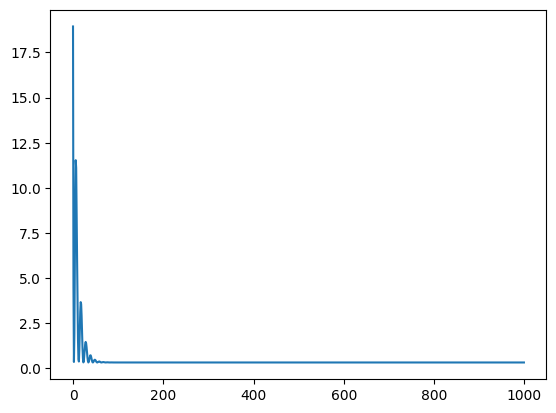

In [29]:
plt.plot(Energys_Adam)

/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


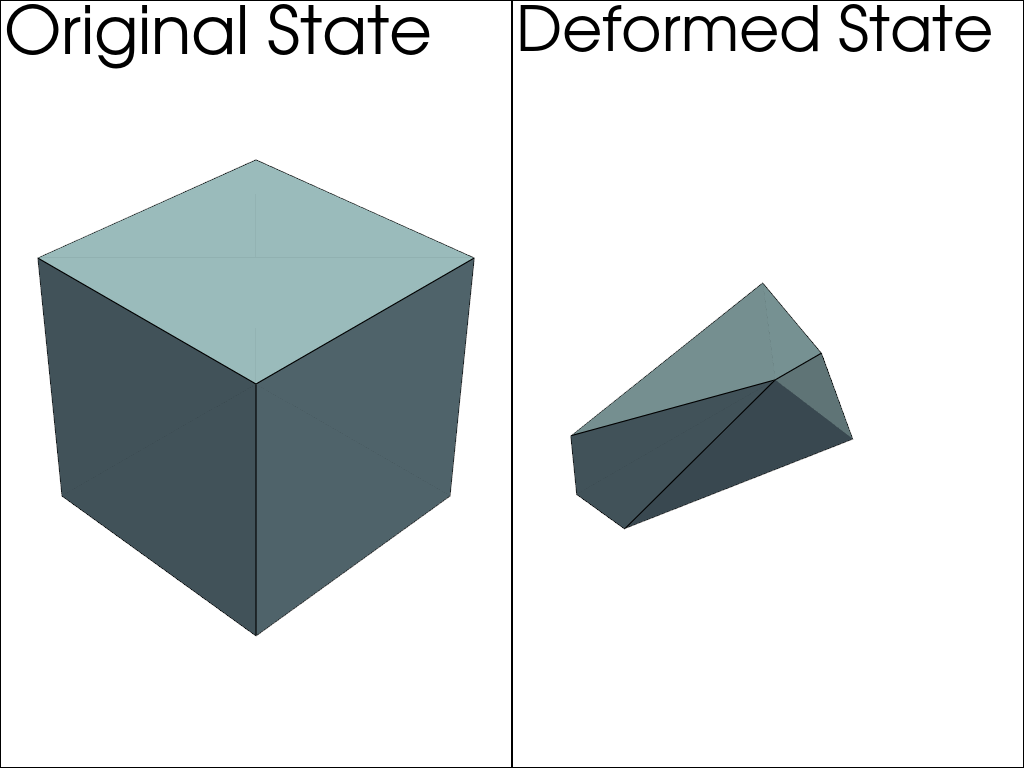

In [13]:
change_state_plot(mesh,u(disp_Adam))

In [99]:
print('Promedio J en los elementos: ',jnp.mean(jnp.linalg.det(malla.f(points_total+ u(disp_GD)))[0]))

Promedio J en los elementos:  1.0111384556734948


## 2x2 Cube

In [8]:
#Mesh SET

mesh_file = '/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Meshes/cube_2x2.msh'
mesh = pv.read(mesh_file)  #Orgiinal File
mesh.clear_data()

points_total,connectivity_total,bc_drichlet_cells,bc_neumann_cells = Hex_Reader(mesh_file,
                                                                                drichlet_bc= ["X_1"],plot = False)


#Dritchlet condition 
bc_drichlet_cells['X_1'] = [bc_drichlet_cells['X_1'], jnp.array([1,0,0]) ]

constant = [0.03,3.77]
material = mat.Delphino(constant,100)
malla = EL.Hexs(material, points_total,connectivity_total)

#Boundary_conditions

X_0_index = jnp.where(points_total[:, 0] == 0)[0]
X_1_index = jnp.where(points_total[:, 0] == 1)[0]
Y_0_index = jnp.where(points_total[:, 1] == 0)[0]
Z_0_index = jnp.where(points_total[:, 2] == 0)[0]


In [9]:
### Optimization 
#result = result.at[:4, :].set(0)
### Loss function
@jit
def loss_function(disp):
    disp = u(disp)
    constant = material.constants
    energia_externa = malla.External_Energy(disp, Dritchlet_BC = bc_drichlet_cells)
    energy_internal = malla.PSI(disp,constant)

    E_pot = energy_internal - energia_externa/1000

    return E_pot #+  (1 + E_pot/jnp.abs(E_pot))*100  

@jit
def u(disp):
    disp = disp.at[X_1_index,0].set(1)
    disp = disp.at[X_0_index,0].set(0)
    disp = disp.at[Y_0_index,1].set(0)
    disp = disp.at[Z_0_index,2].set(0)
    return disp


@jit
def Jacobian(disp):
    J = jax.jacrev(loss_function)(disp)
    #J = jax.grad(loss_2)(disp)
    
    return J



key, subkey = random.split(key)
disp_0  = jnp.zeros_like(points_total)#+random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1e-1) ##Zero initializaiton
# disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)


In [10]:
## Optax Optimizer ADAM

start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

disp_Adam = disp_0

opt_state = optimizer.init(disp_Adam)
Energys_Adam  = []
for _ in range(2000):
  grads = Jacobian(disp_Adam)
  updates, opt_state = optimizer.update(grads, opt_state)
  disp_Adam = optax.apply_updates(disp_Adam, updates)
  Energys_Adam.append(loss_function(disp_Adam))

  # print(_)
  
print('Adam Energy Result',loss_function(disp_Adam)) 
# print(u(disp_Adam))

Adam Energy Result 0.3269221972863828


In [159]:
disp_file  ='/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Displacement_Tests/Cubo_Traccion_X_2x2.npy'
disp_FEM = np.load(disp_file)[-1,:,:]  # The order of this file is [time, node, dim]
print('Energia FEM ', loss_function(jnp.array(disp_FEM)))
# print(disp_FEM)

print(jnp.linalg.norm(disp_FEM - disp_Adam))

Energia FEM  0.3290631521557449
3.000140072703947


In [2]:
plt.plot(Energys_Adam, label = 'Loss function Adam Optimizer')
plt.legend()
plt.grid()

NameError: name 'Energys_Adam' is not defined

/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


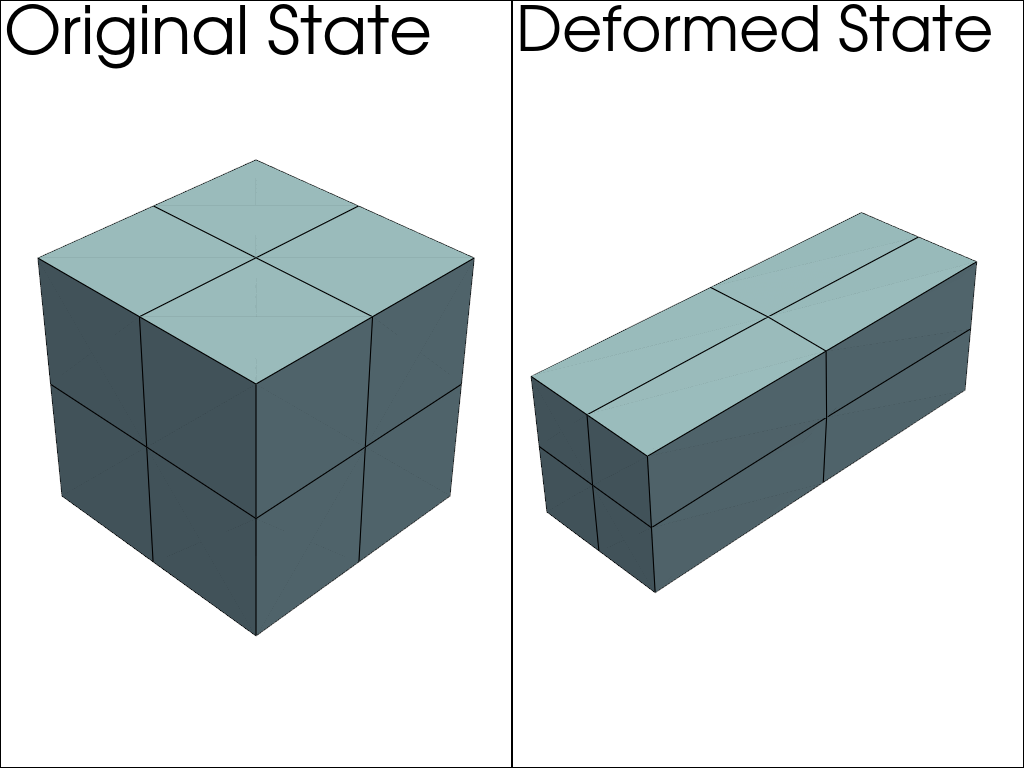

In [166]:
change_state_plot(mesh,u(disp_Adam))

In [167]:
print('Promedio J en los elementos: ',jnp.mean(jnp.linalg.det(malla.f(points_total+ u(disp_Adam)))[0]))

Promedio J en los elementos:  1.0110781071794617


## CASO BIAXIAL

In [2]:
#Mesh SET

mesh_file = '/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Meshes/Biaxial_COARSE.msh'
mesh = pv.read(mesh_file)  #Orgiinal File
mesh.clear_data()

points_total,connectivity_total,bc_drichlet_cells,bc_neumann_cells = Hex_Reader(mesh_file,plot = False)


#Dritchlet condition 
# bc_drichlet_cells['X_1'] = [bc_drichlet_cells['X_1'], jnp.array([1,0,0]) ]

constant = [0.03,3.77]
material = mat.Delphino(constant,100)
malla = EL.Hexs(material, points_total,connectivity_total)

#Boundary_conditions

Sym_Y_index = jnp.where(points_total[:, 1] == 0)[0]
Sym_X_index = jnp.where(points_total[:, 0] == 0)[0]
Sym_Z_index = jnp.where(points_total[:, 2] == 0)[0]
agarreY_index = jnp.where(points_total[:, 1] == 20)[0]
agarreX_index = jnp.where(points_total[:, 0] == 20)[0]

In [3]:
### Optimization 
#result = result.at[:4, :].set(0)
### Loss function
@jit
def loss_function(disp):
    disp = u(disp)
    constant = material.constants
    # energia_externa = malla.External_Energy(disp, Dritchlet_BC = bc_drichlet_cells)
    energy_internal = malla.PSI(disp,constant)

    E_pot = energy_internal #- energia_externa/1000

    return E_pot #+  (1 + E_pot/jnp.abs(E_pot))*100  

@jit
def u(disp):
    disp = disp.at[Sym_Y_index,1].set(0)
    disp = disp.at[Sym_X_index,0].set(0)
    disp = disp.at[Sym_Z_index,2].set(0)
    disp = disp.at[agarreY_index,1].set(5)
    disp = disp.at[agarreX_index,0].set(5)
    return disp


@jit
def Jacobian(disp):
    J = jax.jacrev(loss_function)(disp)
    #J = jax.grad(loss_2)(disp)
    
    return J



key, subkey = random.split(key)
disp_0  = jnp.zeros_like(points_total)#+random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1e-1) ##Zero initializaiton
# disp_0  = random.uniform(key,shape = points_total.shape, minval= 0.0 , maxval= 1.0)
print('Initial Energy', loss_function(disp_0))

Initial Energy 1859.9844350728465


In [4]:
disp_file  ='/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/Testing/Displacement_Tests/Biaxial_Coarse.npy'
disp_FEM = np.load(disp_file)[-1,:,:]  # The order of this file is [time, node, dim]
print('Energia FEM ', loss_function(jnp.array(disp_FEM)))
# print(disp_FEM)

#print(jnp.linalg.norm(disp_FEM - disp_Adam))

Energia FEM  1.7975296785490202


In [13]:
## Optax Optimizer ADAM
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)

disp_Adam = disp_0

opt_state = optimizer.init(disp_Adam)
Energys_Adam  = []
loss_value = 'Start'
for _ in tqdm(range(1000)):
  grads = Jacobian(disp_Adam)
  updates, opt_state = optimizer.update(grads, opt_state)
  disp_Adam = optax.apply_updates(disp_Adam, updates)
  loss_value = loss_function(disp_Adam)
  Energys_Adam.append(loss_value)

  
print('Adam Energy Result',loss_function(disp_Adam)) 

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 17/1000 [00:00<00:05, 165.89it/s]

  3%|▎         | 34/1000 [00:00<00:06, 152.40it/s]

  5%|▌         | 52/1000 [00:00<00:05, 162.11it/s]

  7%|▋         | 69/1000 [00:00<00:05, 157.59it/s]

  9%|▉         | 88/1000 [00:00<00:05, 167.57it/s]

 11%|█         | 107/1000 [00:00<00:05, 174.53it/s]

 12%|█▎        | 125/1000 [00:00<00:05, 173.25it/s]

 14%|█▍        | 144/1000 [00:00<00:04, 176.73it/s]

 16%|█▋        | 163/1000 [00:00<00:04, 180.05it/s]

 18%|█▊        | 182/1000 [00:01<00:05, 161.46it/s]

 20%|██        | 200/1000 [00:01<00:04, 166.33it/s]

 22%|██▏       | 219/1000 [00:01<00:04, 172.72it/s]

 24%|██▍       | 239/1000 [00:01<00:04, 178.65it/s]

 26%|██▌       | 259/1000 [00:01<00:04, 183.17it/s]

 28%|██▊       | 279/1000 [00:01<00:03, 185.90it/s]

 30%|██▉       | 299/1000 [00:01<00:03, 188.42it/s]

 32%|███▏      | 319/1000 [00:01<00:03, 190.47it/s]

 34%|███▍      | 339/1000 [00:01<00:03, 193.14it/s]

 36%|███▌      | 359/1000 [00:02<00:03, 173.55it/s]

 38%|███▊      | 378/1000 [00:02<00:03, 177.12it/s]

 40%|███▉      | 398/1000 [00:02<00:03, 181.36it/s]

 42%|████▏     | 417/1000 [00:02<00:03, 182.01it/s]

 44%|████▎     | 436/1000 [00:02<00:03, 182.36it/s]

 46%|████▌     | 455/1000 [00:02<00:03, 181.11it/s]

 47%|████▋     | 474/1000 [00:02<00:02, 181.65it/s]

 49%|████▉     | 494/1000 [00:02<00:02, 185.20it/s]

 51%|█████▏    | 513/1000 [00:02<00:02, 186.39it/s]

 53%|█████▎    | 532/1000 [00:03<00:02, 172.24it/s]

 55%|█████▌    | 550/1000 [00:03<00:02, 170.58it/s]

 57%|█████▋    | 568/1000 [00:03<00:02, 172.68it/s]

 59%|█████▉    | 588/1000 [00:03<00:02, 179.85it/s]

 61%|██████    | 607/1000 [00:03<00:02, 182.55it/s]

 63%|██████▎   | 626/1000 [00:03<00:02, 182.63it/s]

 65%|██████▍   | 646/1000 [00:03<00:01, 185.71it/s]

 66%|██████▋   | 665/1000 [00:03<00:01, 182.55it/s]

 68%|██████▊   | 685/1000 [00:03<00:01, 185.31it/s]

 70%|███████   | 705/1000 [00:03<00:01, 189.30it/s]

 72%|███████▏  | 724/1000 [00:04<00:01, 172.14it/s]

 74%|███████▍  | 745/1000 [00:04<00:01, 181.18it/s]

 77%|███████▋  | 766/1000 [00:04<00:01, 187.86it/s]

 79%|███████▊  | 787/1000 [00:04<00:01, 192.09it/s]

 81%|████████  | 807/1000 [00:04<00:00, 193.90it/s]

 83%|████████▎ | 828/1000 [00:04<00:00, 196.89it/s]

 85%|████████▍ | 848/1000 [00:04<00:00, 195.69it/s]

 87%|████████▋ | 868/1000 [00:04<00:00, 195.82it/s]

 89%|████████▉ | 889/1000 [00:04<00:00, 199.14it/s]

 91%|█████████ | 909/1000 [00:05<00:00, 179.47it/s]

 93%|█████████▎| 928/1000 [00:05<00:00, 181.90it/s]

 95%|█████████▍| 947/1000 [00:05<00:00, 182.13it/s]

 97%|█████████▋| 966/1000 [00:05<00:00, 183.73it/s]

 99%|█████████▊| 986/1000 [00:05<00:00, 187.55it/s]

100%|██████████| 1000/1000 [00:05<00:00, 181.21it/s]

Adam Energy Result 7.525773763184938


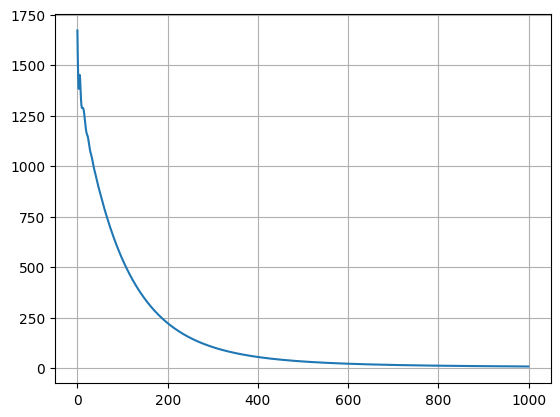

In [10]:
plt.plot(Energys_Adam, label = 'Loss function Adam Optimizer')
plt.grid()

/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/nicolas/Escritorio/Low-Dimension-Deep-Energy/env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


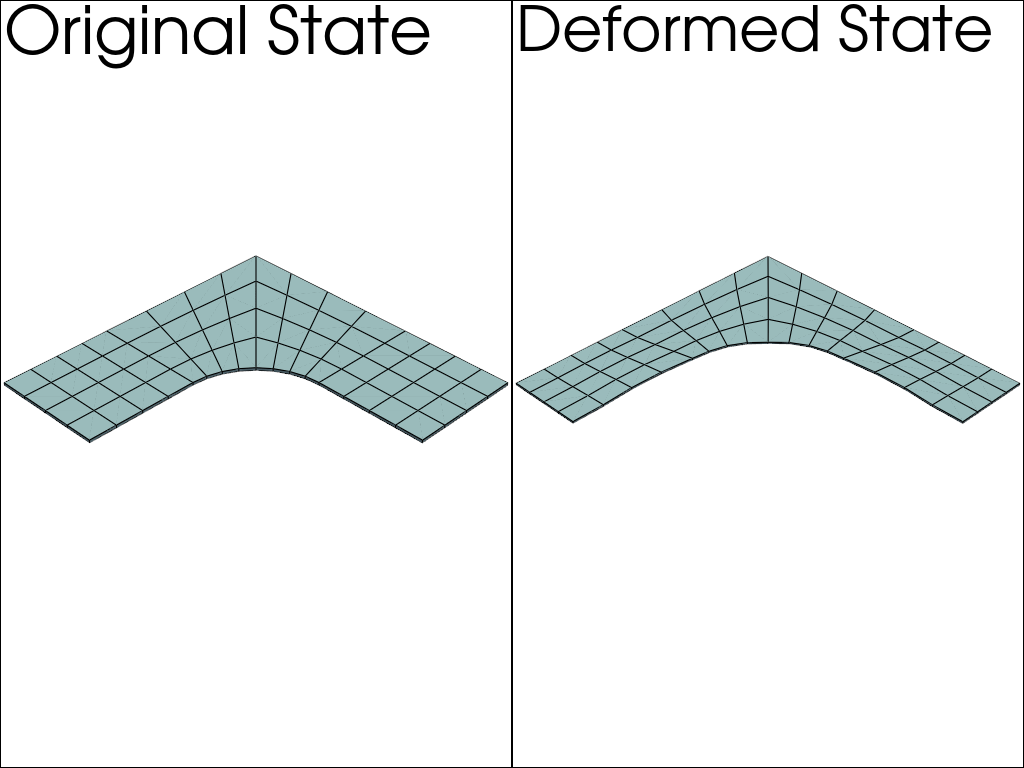

Promedio J en los elementos:  1.0049114974379552


In [55]:
change_state_plot(mesh,u(disp_Adam))
print('Promedio J en los elementos: ',jnp.mean(jnp.linalg.det(malla.f(points_total+ u(disp_Adam)))[0]))